## 今回のテーマ
- 検診データにより肝疾患判定
- 健康診断データに基づいた肝疾患の有無を判定するモデルの構築

## データについて

| ヘッダ名称 | データ型 | 説明 |
| ---- | ---- | ---- |
| id | int | インデックスとして使用 |
| Age | int | 年齢 |
| Gender | char | 性別 |
| T_Bill | float | 検査項目1： 総ビリルビン (Total Bilirubin) |
| D_Bill | float | 検査項目2： 直接ビリルビン (Direct Bilirubin) |
| ALP | float | 検査項目3： アルカリフォスファター ゼ (Alkaline Phosphotase) |
| ALT_GPT | float | 検査項目4： アラニンアミノトランスフェラーゼ (Alanine Transaminase) |
| AST_GPT | float | 検査項目5： アスパラギン酸アミノトランスフェラーゼ (Aspartate Aminotransferase) |
| TP | float | 検査項目6： 総タンパク (Total Protiens) |
| Ab | float | 検査項目7： アルブミン (Albumin) |
| AG_ratio | float | 検査項目8： アルブミン/グロブリン比 |
| disease | int | 肝疾患の有無（0:無, 1:有） |

In [5]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
#import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline

In [37]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
print(train_df.shape)
display(train_df.head())
print(test_df.shape)
display(test_df.head())

(850, 11)


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


(350, 10)


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [3]:
train_df.dtypes

Age           int64
Gender       object
T_Bil       float64
D_Bil       float64
ALP         float64
ALT_GPT     float64
AST_GOT     float64
TP          float64
Alb         float64
AG_ratio    float64
disease       int64
dtype: object

KeyboardInterrupt: 

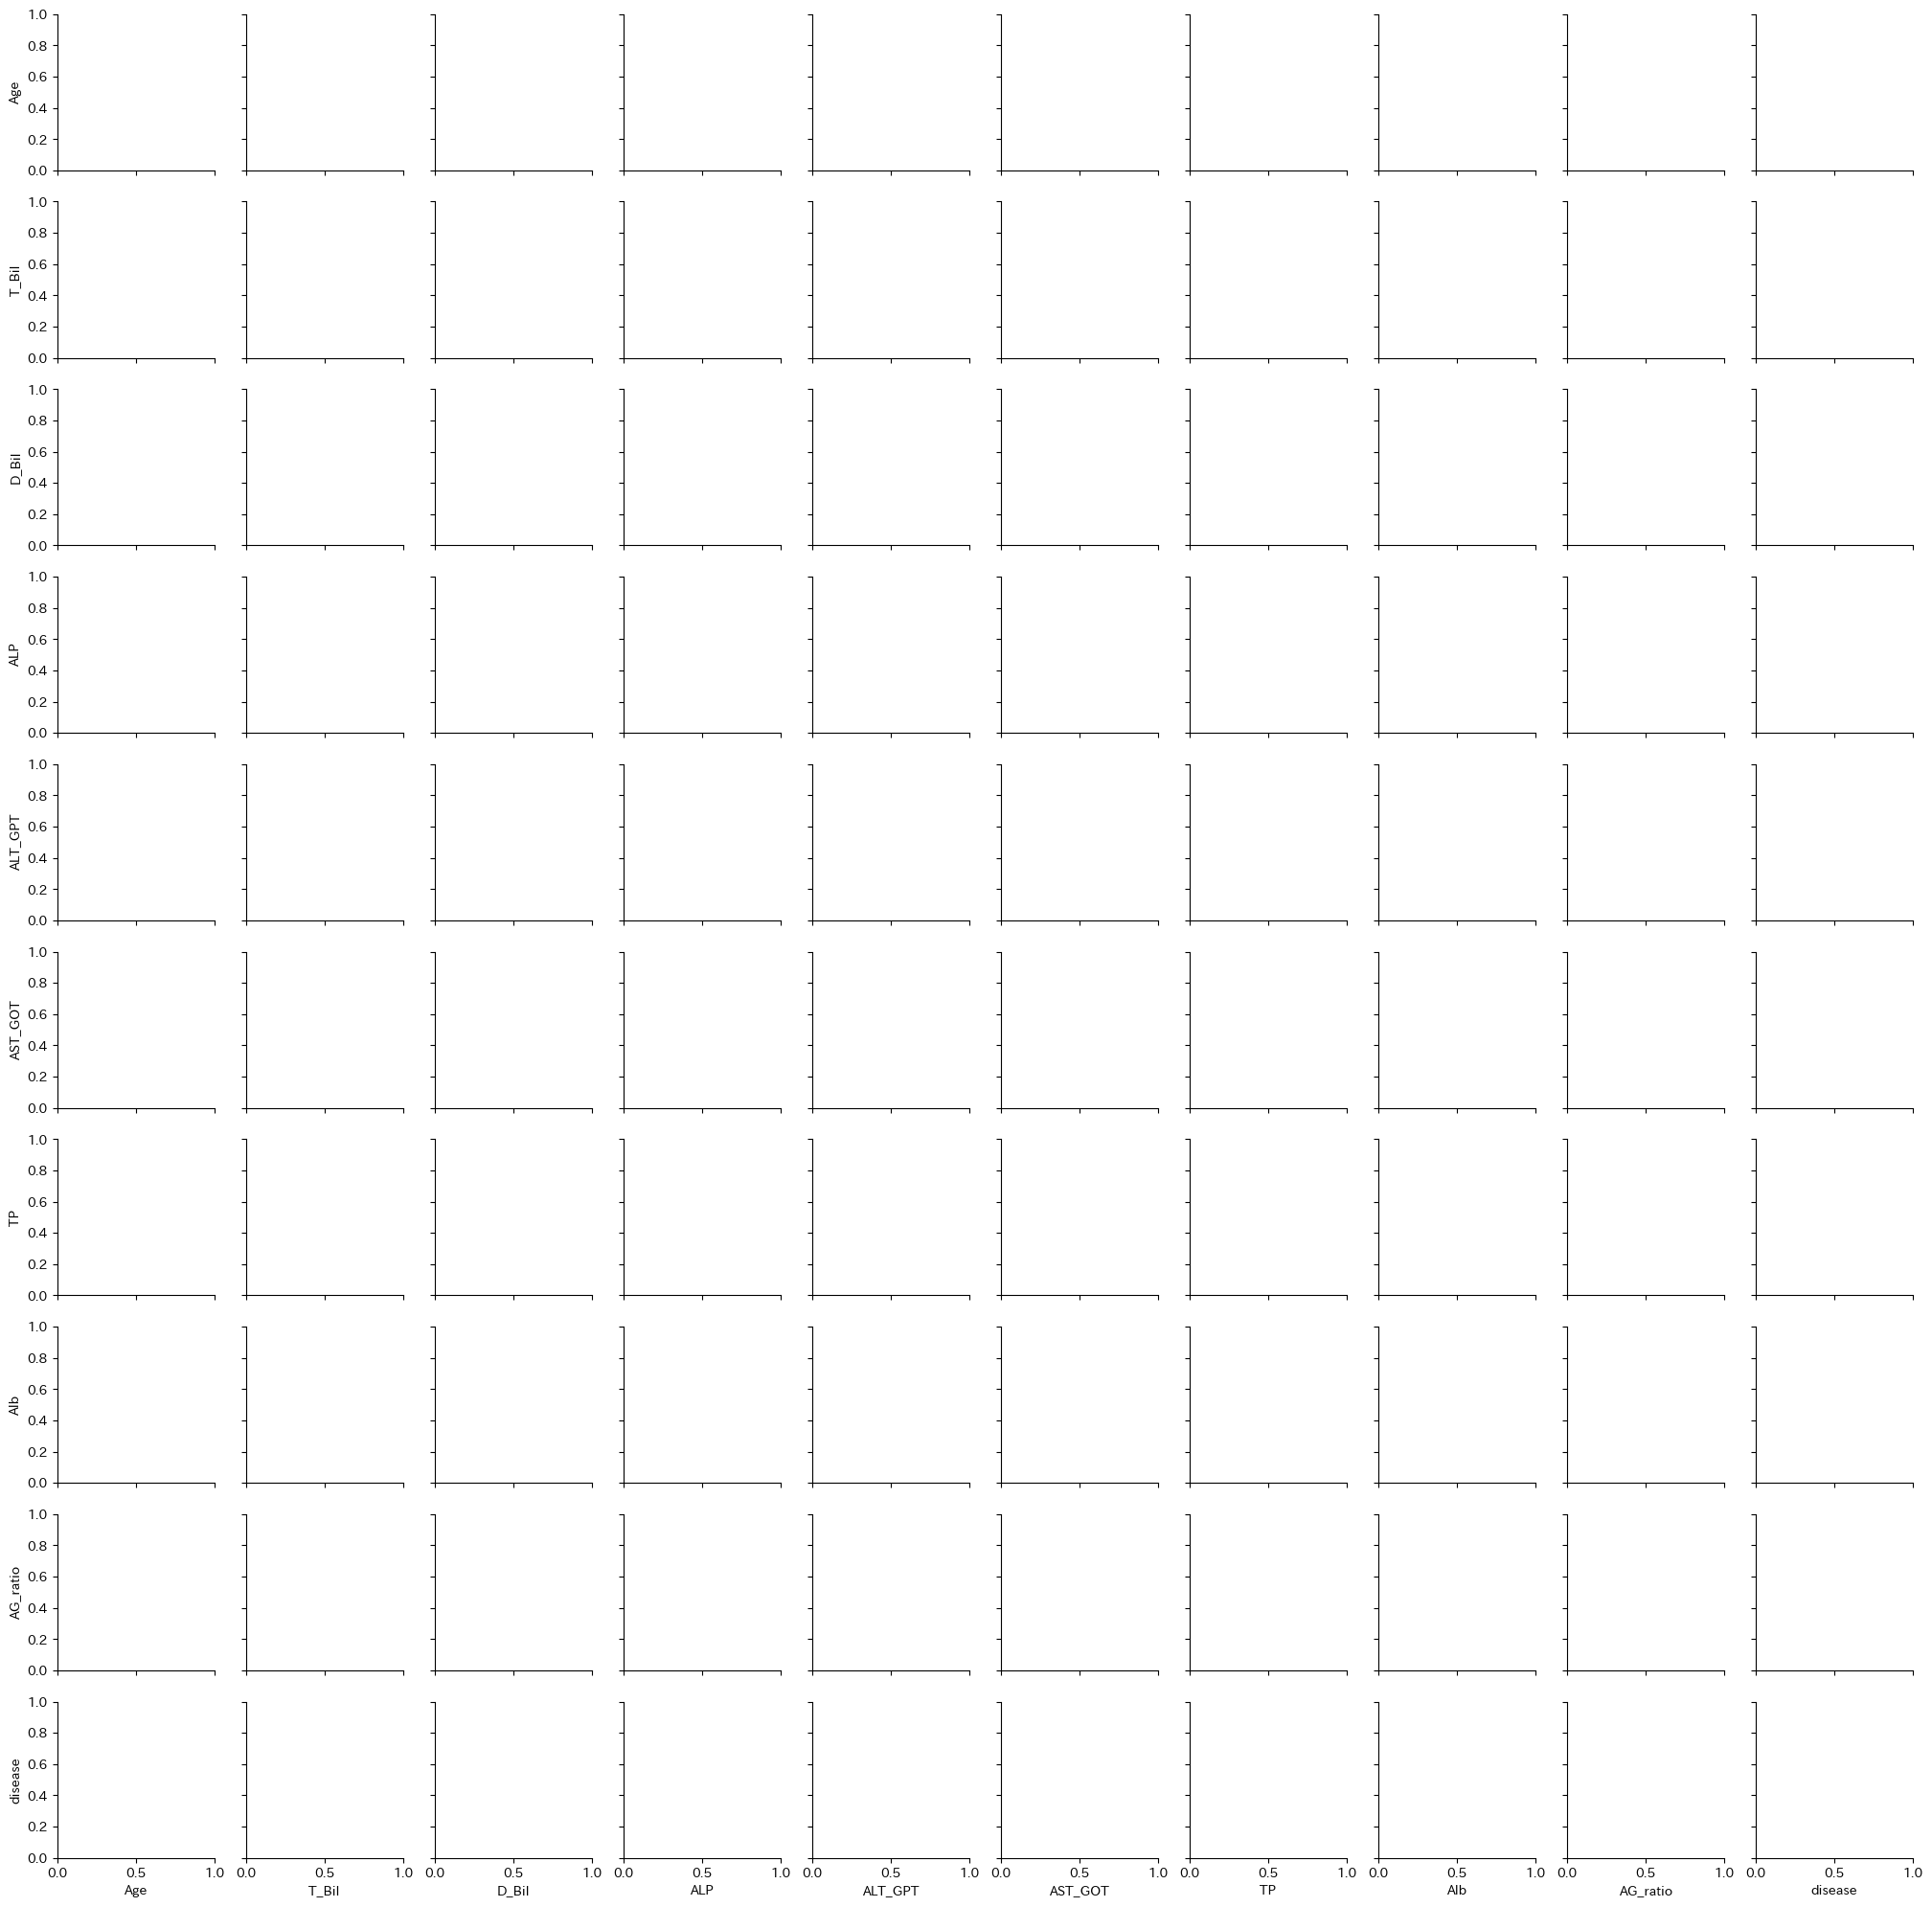

In [4]:
sns.pairplot(train_df)

In [17]:
train_df.columns.tolist()

['Age',
 'Gender',
 'T_Bil',
 'D_Bil',
 'ALP',
 'ALT_GPT',
 'AST_GOT',
 'TP',
 'Alb',
 'AG_ratio',
 'disease']

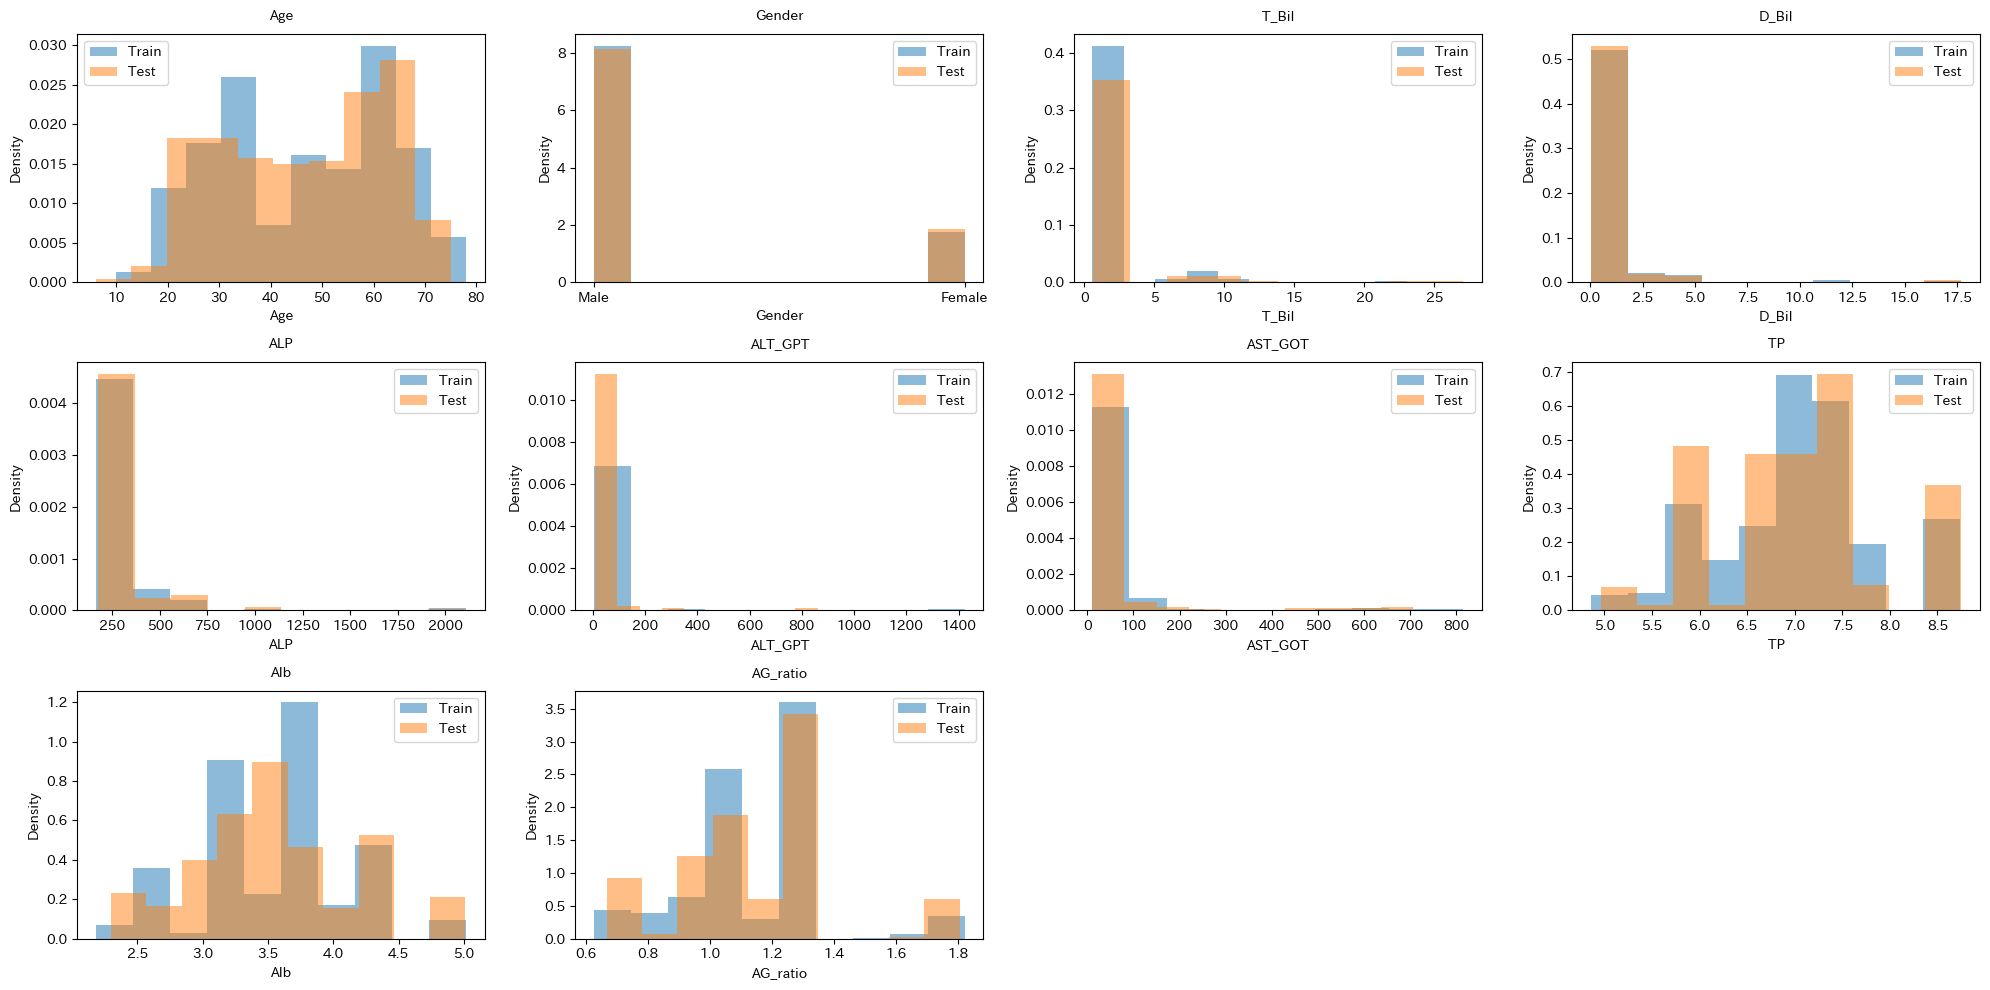

In [12]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.7)  # サブプロット間の縦スペースを調整

for i, column in enumerate(train_df.columns.tolist()[:-1]):
    ax = axes[i // 4, i % 4]  # インデックスに応じて適切なサブプロットを選択

    # "True"のデータと"False"のデータをそれぞれ抽出
    train_data = train_df[column]
    test_data = test_df[column]

    # ヒストグラムを描画
    ax.hist(train_data, bins=10, alpha=0.5, label="Train", density=True)
    ax.hist(test_data, bins=10, alpha=0.5, label="Test", density=True)

    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.set_title(column, fontsize=10, pad=10)  # 日本語タイトルを追加
    ax.legend()  # 凡例を表示

# 不足分のサブプロットを非表示にする
for i in range(len(train_df.columns.tolist()[:-1]), 3 * 4):
    axes[i // 4, i % 4].axis('off')

plt.tight_layout()  # レイアウトを調整してタイトルが被らないようにする
plt.show()


<AxesSubplot: xlabel='disease', ylabel='Count'>

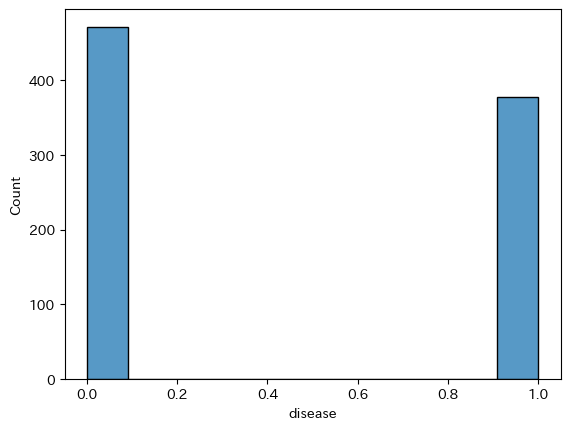

In [14]:
sns.histplot(train_df["disease"])

In [5]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
dtype: int64


In [8]:
train_df.describe()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Gender_Female
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,46.610588,1.607337,0.606737,272.211316,41.978476,61.018120,7.032290,3.517458,1.144570,0.444706,0.174118
std,16.453672,2.443585,1.569032,200.348515,145.927366,110.125390,0.840664,0.559942,0.227237,0.497226,0.379434
min,10.000000,0.585961,0.034861,163.261838,3.924518,11.283497,4.858679,2.180884,0.627133,0.000000,0.000000
25%,32.000000,0.781258,0.144889,213.991414,13.644658,21.239157,6.730612,3.139153,1.004466,0.000000,0.000000
50%,48.000000,0.835591,0.194085,220.092503,16.638001,27.056026,6.915580,3.621339,1.205016,0.000000,0.000000
75%,62.000000,1.196759,0.335447,229.455927,23.056081,56.461568,7.536151,3.712524,1.287880,1.000000,0.000000
max,78.000000,23.017027,17.692164,2108.483728,1423.186473,814.439397,8.739000,5.016970,1.821496,1.000000,1.000000


## 前処理
- カテゴリデータ
    - One-hotエンコーディング

In [38]:
# データの前処理
# カテゴリカル変数 Gender の One-Hot エンコーディングを行う
train_df = pd.get_dummies(train_df, columns=['Gender']).iloc[:, :-1]
test_df = pd.get_dummies(test_df, columns=['Gender']).iloc[:, :-1]

df = pd.concat([train_df, test_df], axis=0)
df.reset_index(inplace=True, drop=True)

display(train_df.head())
display(test_df.head())
display(df.head())

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Gender_Female
0,59,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0,0
1,69,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1,0
2,65,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0,0
3,65,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1,0
4,22,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0,1


,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Gender_Female
0,25,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006,0
1,26,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562,1
2,64,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579,0
3,65,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070,0
4,34,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078,1


,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Gender_Female
0,59,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0.0,0
1,69,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1.0,0
2,65,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0.0,0
3,65,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1.0,0
4,22,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0.0,1


In [28]:
df.iloc[848:855]

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Gender_Female,is_test
848,32,0.761972,0.137969,214.170393,18.048321,54.447774,5.944855,3.150978,1.220787,0.0,1,0
849,64,0.762713,0.218435,214.720510,15.885571,24.789606,6.768439,3.686097,1.309895,0.0,0,0
850,25,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006,NaN,0,1
851,26,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562,NaN,1,1
852,64,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579,NaN,0,1
853,65,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070,NaN,0,1
854,34,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078,NaN,1,1


In [35]:
df.isnull().sum()

Age         0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
dtype: int64

In [39]:
from sklearn.preprocessing import StandardScaler
X = df.drop(columns=['disease'])
y = df["disease"]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_df = pd.DataFrame(data=X_sc, columns=X.columns)
display(X_df.head())

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Gender_Female
0,0.755798,-0.322171,-0.274075,-0.274077,-0.196400,-0.353906,-0.273915,-0.728266,-0.602987,-0.464549
1,1.367161,-0.237658,-0.246244,-0.268892,0.090606,0.032126,-0.187143,-0.834104,-1.697690,-0.464549
2,1.122616,-0.372679,-0.316759,0.227596,-0.202837,-0.274193,-1.293381,-1.813751,-1.596534,-0.464549
3,1.122616,-0.275482,-0.234805,0.469514,-0.036875,-0.059774,-0.096028,0.145478,-0.682895,-0.464549
4,-1.506246,0.046897,-0.244961,-0.261093,-0.142115,0.976569,-1.422851,-0.804182,-0.517911,2.152627


In [46]:
print(X_df.shape)
print(y.shape)

(1200, 10)
(1200,)


In [48]:
df_sc = pd.concat([X_df, y], axis=1)
train_df_sc = df_sc[:850]
test_df_sc = df_sc[850:].drop(columns="disease")
test_df_sc.reset_index(inplace=True, drop=True)

display(train_df_sc.head())
display(test_df_sc.head())

# X_train, X_test, Y_train, Y_test = train_test_split(X_df, y, test_size=0.3, random_state=0)
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Gender_Female,disease
0,0.755798,-0.322171,-0.274075,-0.274077,-0.196400,-0.353906,-0.273915,-0.728266,-0.602987,-0.464549,0.0
1,1.367161,-0.237658,-0.246244,-0.268892,0.090606,0.032126,-0.187143,-0.834104,-1.697690,-0.464549,1.0
2,1.122616,-0.372679,-0.316759,0.227596,-0.202837,-0.274193,-1.293381,-1.813751,-1.596534,-0.464549,0.0
3,1.122616,-0.275482,-0.234805,0.469514,-0.036875,-0.059774,-0.096028,0.145478,-0.682895,-0.464549,1.0
4,-1.506246,0.046897,-0.244961,-0.261093,-0.142115,0.976569,-1.422851,-0.804182,-0.517911,2.152627,0.0


,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Gender_Female
0,-1.322837,-0.316367,-0.251687,-0.302654,-0.182702,-0.373938,-0.271364,0.122684,0.602057,-0.464549
1,-1.261701,-0.303497,-0.295088,-0.204465,-0.219003,-0.398733,-0.297756,-0.730413,-0.501165,2.152627
2,1.061479,-0.320246,-0.244816,-0.294718,-0.187914,-0.363178,0.558016,0.169491,0.561661,-0.464549
3,1.122616,-0.303830,-0.258507,-0.370218,-0.201345,-0.368502,-0.258202,0.167988,0.546623,-0.464549
4,-0.772610,-0.359772,-0.283323,-0.331294,-0.144360,-0.323691,1.896415,1.115648,0.568083,2.152627


In [49]:
X = train_df_sc.drop(columns="disease")
Y = train_df_sc["disease"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [50]:
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰:警告がでるため「solver='lbfgs'」を与えている
logistic_model = LogisticRegression(solver='lbfgs')
logistic_model.fit(X_train, Y_train)
Y_pred = logistic_model.predict(X_valid)

# モデルの評価
print(classification_report(Y_valid, Y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86        99
         1.0       0.87      0.74      0.80        80

    accuracy                           0.83       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.83      0.83       179



In [55]:
Y_pred_test = logistic_model.predict(X_test)
print(Y_pred_test)
print(Y_pred_test.shape)

[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.]
(255,)


In [56]:
print(classification_report(Y_test, Y_pred_test))

              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86       150
         1.0       0.88      0.68      0.76       105

    accuracy                           0.83       255
   macro avg       0.84      0.80      0.81       255
weighted avg       0.83      0.83      0.82       255



In [60]:
pred = logistic_model.predict(test_df_sc)
print(pred)
print(pred.shape)
# print(classification_report(test_df_sc, pred))

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.

In [66]:
result = pd.DataFrame(data=pred)
result = result.astype("int")
result.head()

,0
0,0
1,0
2,0
3,0
4,0


In [68]:
result.to_csv("submit.csv", header=False)

## 1回目の提出結果
- 評価結果：0.7435070306038049